In [1]:
import numpy as np

In [98]:
from scipy.optimize import curve_fit

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm

In [3]:
import itertools

In [4]:
import seaborn as sns
sns.set(style="ticks", color_codes=True, font_scale=1.)
sns.set_style({"xtick.direction": "in", "ytick.direction": "in"})

In [5]:
import mdtraj as md

# Dilute boxes

In [183]:
data = np.loadtxt("lj_binding_equil.csv", delimiter=',')

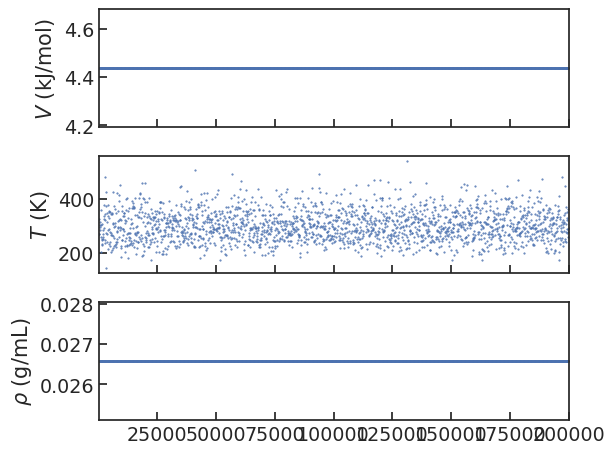

In [184]:
fig, ax = plt.subplots(3,1, sharex=True, sharey=False)
ax[0].plot(data[:,0], data[:,1], '.', ms=1)
#ax[0].set_ylim(-30000,200)
ax[0].set_ylabel(r'$V$ (kJ/mol)')

ax[1].plot(data[:,0], data[:,2], '.', ms=1)
#ax[1].set_ylim(250,350)
ax[1].set_ylabel(r'$T$ (K)')

ax[2].plot(data[:,0], data[:,3], '.', ms=1)
ax[2].set_ylabel(r'$\rho$ (g/mL)')
ax[2].set_xlim(data[0,0], data[-1,0])
plt.tight_layout()

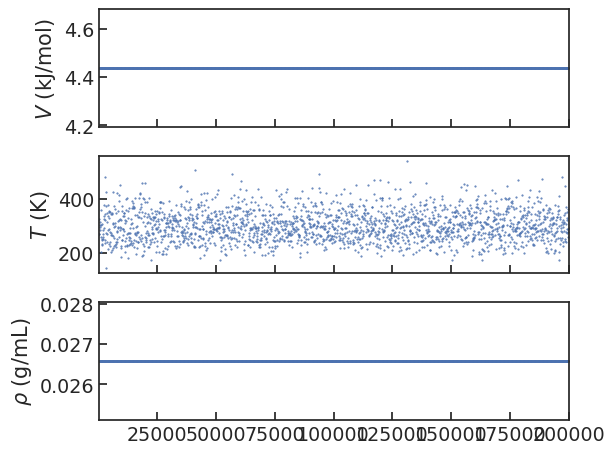

In [185]:
fig, ax = plt.subplots(3,1, sharex=True, sharey=False)
ax[0].plot(data[:,0], data[:,1], '.', ms=1)
#ax[0].set_ylim(-30000,200)
ax[0].set_ylabel(r'$V$ (kJ/mol)')

ax[1].plot(data[:,0], data[:,2], '.', ms=1)
#ax[1].set_ylim(250,350)
ax[1].set_ylabel(r'$T$ (K)')

ax[2].plot(data[:,0], data[:,3], '.', ms=1)
ax[2].set_ylabel(r'$\rho$ (g/mL)')
ax[2].set_xlim(data[0,0], data[-1,0])
plt.tight_layout()

In [186]:
data = np.loadtxt("lj_binding_prod.csv", delimiter=',')

In [187]:
traj = md.load_dcd("lj_binding_prod.dcd", top="lj_binding_min.pdb", stride=1)

In [211]:
bins, g_r = md.compute_rdf(traj, list(itertools.combinations(range(20), 2)), \
                               r_range=[1,25], n_bins=200)

/tmp/ipykernel_6724/1872191056.py:4: RuntimeWarning: divide by zero encountered in log
  axt.plot(bins, -np.log(g_r), color='C1')


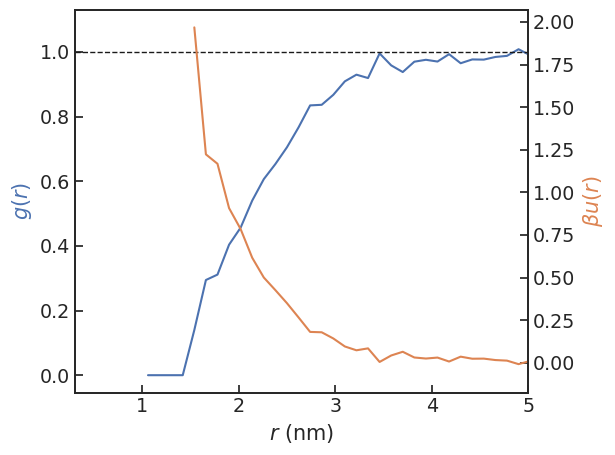

In [212]:
fig, ax = plt.subplots()
ax.plot(bins, g_r)
axt = ax.twinx()
axt.plot(bins, -np.log(g_r), color='C1')
ax.axhline(1,0,2,ls='dashed', lw=1, color='k')
ax.set_xlim(0.3,5)
ax.set_xlabel('$r$ (nm)')
ax.set_ylabel(r'$g(r)$', color='C0')
axt.set_ylabel(r'$\beta u(r)$', color='C1')
plt.tight_layout()

In [213]:
distances = md.compute_distances(traj, \
                                atom_pairs=list(itertools.combinations(range(20), 2)))

In [214]:
ldist = len(list(itertools.combinations(range(20), 2)))

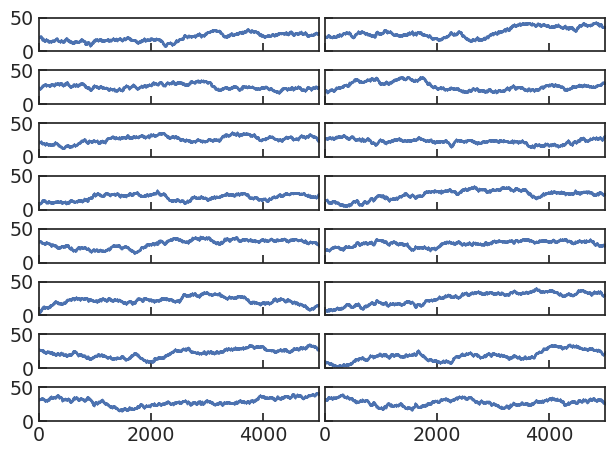

In [222]:
fig, ax = plt.subplots(8,2, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(ldist)[:16]:
    ax[i].plot(traj.time, distances[:,i], '.', ms=0.5)
ax[i].set_xlim(0,5000); ax[i].set_ylim(0,50)
plt.tight_layout(w_pad=0, h_pad=0)

In [218]:
nbins = 100
hist, bin_edges = np.histogram(np.concatenate(distances), density=True, bins=np.linspace(0,30,nbins))
bin_centers = np.array([0.5*(bin_edges[i]+bin_edges[i+1]) for i in range(nbins-1)])

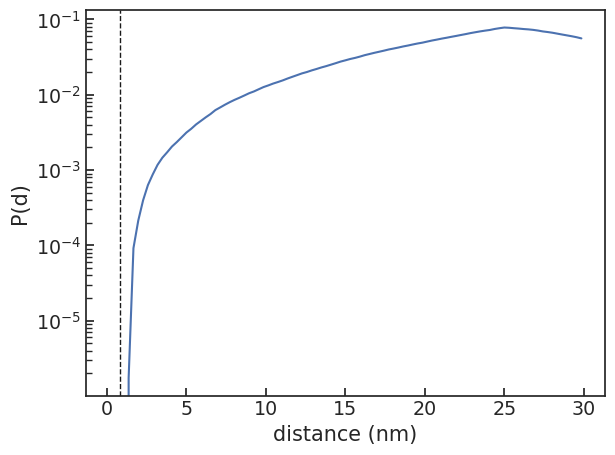

In [220]:
fig, ax = plt.subplots()
ax.plot(bin_centers, hist)
ax.axvline(0.8,0,1, ls='dashed', color='k', lw=1)
ax.set_xlabel('distance (nm)')
ax.set_ylabel('P(d)')
ax.set_yscale('log')
#ax.set_ylim(1e-3,1); ax.set_xlim(0,9)
plt.tight_layout()

In [182]:
ibound = np.argmin(np.abs(bin_centers - 0.8))
pb = np.trapz(hist[:ibound], dx=bin_centers[1]-bin_centers[0])
print ('Population bound = %e'%pb)

Population bound = 3.083500e-03


# Dense phases

In [44]:
system = "xenon"

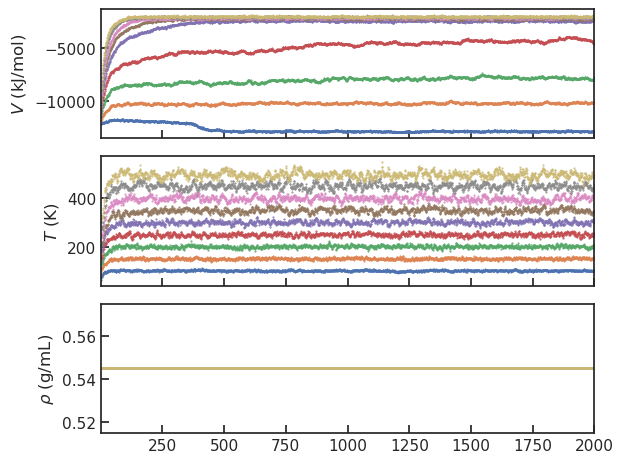

In [48]:
fig, ax = plt.subplots(3,1, sharex=True, sharey=False)
for t in range(100,510,50):
    data = np.loadtxt("data/%s_slab_T%g_equil.csv"%(system,t), delimiter=',')
    ax[0].plot(data[:,0], data[:,1], '.', ms=1)
    #ax[0].set_ylim(-30000,200)
    ax[1].plot(data[:,0], data[:,2], '.', ms=1)
    ax[2].plot(data[:,0], data[:,3], '.', ms=1)
ax[0].set_ylabel(r'$V$ (kJ/mol)')
#ax[1].set_ylim(250,350)
ax[1].set_ylabel(r'$T$ (K)')
ax[2].set_ylabel(r'$\rho$ (g/mL)')
ax[2].set_xlim(data[0,0], data[-1,0])
plt.tight_layout()

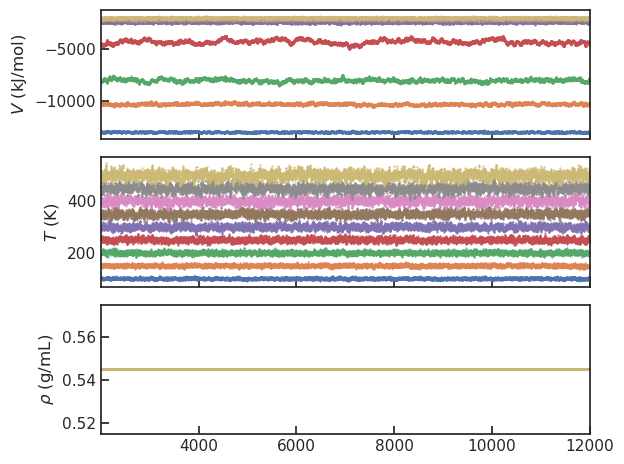

In [49]:
fig, ax = plt.subplots(3,1, sharex=True, sharey=False)
for t in range(100,510,50):
    data = np.loadtxt("data/%s_slab_T%g_prod.csv"%(system,t), delimiter=',')
    ax[0].plot(data[:,0], data[:,1], '.', ms=1)
    #ax[0].set_ylim(-30000,200)
    ax[1].plot(data[:,0], data[:,2], '.', ms=1)
    ax[2].plot(data[:,0], data[:,3], '.', ms=1)
ax[0].set_ylabel(r'$V$ (kJ/mol)')
#ax[1].set_ylim(250,350)
ax[1].set_ylabel(r'$T$ (K)')
ax[2].set_ylabel(r'$\rho$ (g/mL)')
ax[2].set_xlim(data[0,0], data[-1,0])
plt.tight_layout()

/tmp/ipykernel_85192/2311999559.py:7: RuntimeWarning: divide by zero encountered in log
  ax[1].plot(bins, -np.log(g_r))


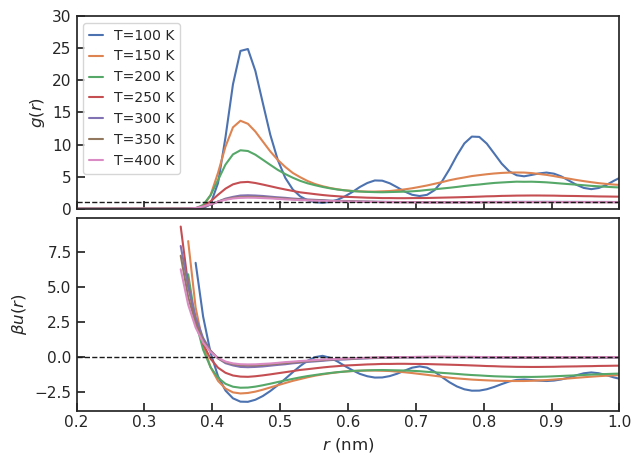

In [72]:
fig, ax = plt.subplots(2,1, sharex=True)
for t in range(100,410,50):
    traj = md.load_dcd("data/%s_slab_T%g_prod.dcd"%(system,t), top="data/%s_slab_T%g_min.pdb"%(system,t), stride=20)
    bins, g_r = md.compute_rdf(traj, list(itertools.combinations(range(1000), 2)), \
                               r_range=[0.15,1.25], n_bins=100)
    ax[0].plot(bins, g_r, label='T=%g K'%t)
    ax[1].plot(bins, -np.log(g_r))

ax[0].axhline(1,0,1,ls='dashed', lw=1, color='k')
ax[1].axhline(0,0,1,ls='dashed', lw=1, color='k')
ax[0].set_xlim(0.2,1)
ax[0].set_ylim(0,30)
ax[1].set_xlabel('$r$ (nm)')
ax[0].set_ylabel(r'$g(r)$')
ax[1].set_ylabel(r'$\beta u(r)$')
ax[0].legend(loc=2, fontsize=10, handlelength=1)
plt.tight_layout(h_pad=0)

/tmp/ipykernel_85192/539300829.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc=0, fontsize=10, handlelength=1)


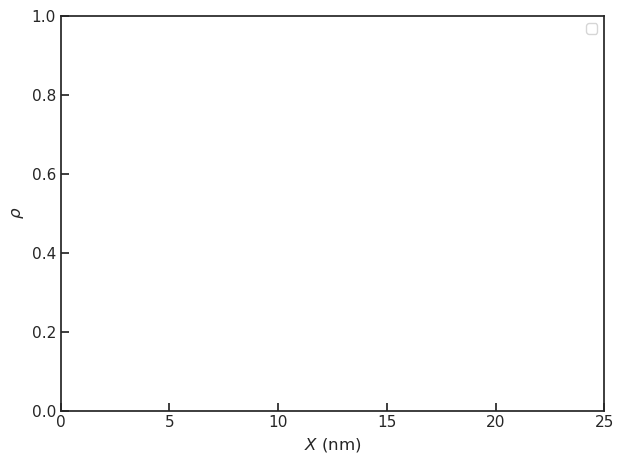

In [153]:
fig, ax = plt.subplots()
for t in range(100,410,50):
    traj = md.load_dcd("data/%s_slab_T%g_prod.dcd"%(system,t), top="data/%s_slab_T%g_min.pdb"%(system,t), stride=20)
    #traj.center_coordinates()
    hists = np.array([np.histogram(traj.xyz[i,:,0], bins=np.linspace(0,25,51), density=True)[0] for i in range(500)])
    
    break

ax.set_xlim(0.,25)
ax.set_xlabel('$X$ (nm)')
ax.set_ylabel(r'$\rho$')
ax.legend(loc=0, fontsize=10, handlelength=1)
plt.tight_layout(h_pad=0)

In [105]:
system = "krypton" # ["neon", "argon", "krypton", "xenon"]:
temps = list(range(100, 450, 25))

fig, ax = plt.subplots(4,4, sharex=True, sharey=True)
fig2, ax2 = plt.subplots(4,4, sharex=True, sharey=True)


ax = ax.flatten()
for i,t in enumerate(temps) :
    traj = md.load_dcd("data/%s_slab_T%g_equil.dcd"%(system,t), top="data/%s_slab_T%g_min.pdb"%(system,t), stride=10)
    hists = np.array([np.histogram(traj.xyz[i,:,0], bins=np.linspace(0,25,51), \
                                   density=True)[0] for i in range(traj.n_frames)])
    ax[i].imshow(hists, aspect=0.1, cmap='binary_r')
    ax[i].text(0.65,0.1,'T=%g K'%t, transform=ax[i].transAxes, fontsize=8, \
               bbox=dict(facecolor='lightgray', alpha=0.9, boxstyle='round', pad=0.25))
    
  ax2[i].plot(x, np.mean(hists[:20]))
  break
plt.tight_layout(w_pad=0, h_pad=0)

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 17)

In [99]:
def tanh_function(x, p0, p1, p2, p3):
    return p0 + p1*(np.tanh(p2-x) + (1 - np.tanh(p3-x)) + 1)/2 

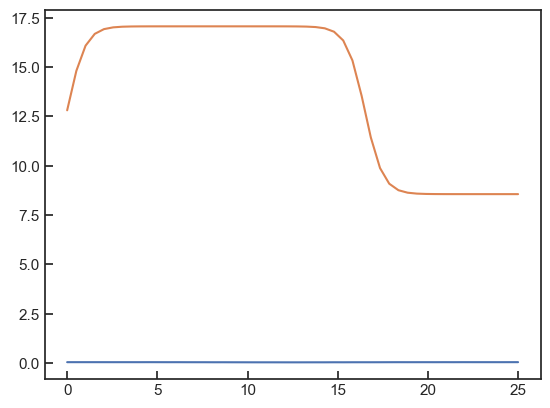

In [100]:
p0 = [0.055, 8.5, 16.5, 0.0008]

x = np.linspace(0,25,50)
plt.plot(x, np.mean(hists[:20], axis=0))
plt.plot(x,tanh_function(x, *p0))

In [101]:
popt, pcov = curve_fit(tanh_function, x, np.mean(hists[:20], axis=0), p0=p0, bounds=[0., [0.1, 25, 25, 0.1]])

In [102]:
popt

array([3.55920858e-02, 3.54578227e-03, 6.43259340e+00, 8.21195588e-18])

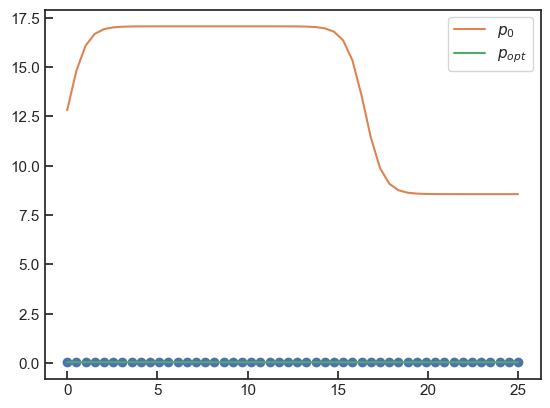

In [103]:
plt.plot(x, np.mean(hists[:20], axis=0), 'o')
plt.plot(x, tanh_function(x, *p0), label='$p_0$')
plt.plot(x, tanh_function(x, *popt), label='$p_{opt}$')
plt.legend()